In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns


from elephant.conversion import BinnedSpikeTrain
from elephant import kernels
from elephant.spike_train_correlation import correlation_coefficient
from elephant import statistics
from matplotlib import gridspec
from tqdm import tqdm_notebook as tqdm
#from utils import *
from viziphant.rasterplot import rasterplot, rasterplot_rates
from viziphant.spike_train_correlation import plot_corrcoef

In [3]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [4]:
path = "data/"

### Brunel Model

In [4]:
# Fixed model parameters
order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# NEST settings
threads = 16        # number of threads to use in simulation
print_time = True   # print simulated time or not

# simulator model
bnet = nm.models.BrunelNet(order=order,
                           epsilon=epsilon,
                           D=D,
                           J=J,
                           T=T,
                           N_rec=N_rec,
                           n_type=n_type,
                           print_time=print_time,
                           threads=threads
                           )

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

def slice_spiketrains(spiketrains, t_start=None, t_stop=None):

    spiketrains_slice = []
    for spiketrain in spiketrains:
        if t_start is None:
            t_start = spiketrain.t_start
        if t_stop is None:
            t_stop = spiketrain.t_stop

        spiketrain_slice = spiketrain[np.where(
            (spiketrain > t_start) & (spiketrain < t_stop))]
        spiketrain_slice.t_start = t_start
        spiketrain_slice.t_stop = t_stop
        spiketrains_slice.append(spiketrain_slice)
    return spiketrains_slice

Simulation of a network of $N_\mathrm{E}=10,000$ excitatory and $N_\mathrm{I} = 2,500$ inhibitory neurons with connection probability $\epsilon = 0.1$, which corresponds to a network where each neuron has $C_\mathrm{E}=1,000$ and $C_\mathrm{I}=250$ randomly selected connections to excitatory and inhibitory neurons, respectively. Each spike causes, after a delay of $D=1.5$ ms (synaptic delay), a voltage jump of $J_E = 0.1$ mV (amplitude of excitatory synaptic currents). The distance from equilibrium potential to firing threshold is $V_\mathrm{th} = 20$ mV; absolute refractory period $\tau_\mathrm{rp} = 2$ ms; membrane time constant $\tau_\mathrm{m}=20$ ms; membrane capacitance $C_m = 1$ pF. The network is simulated for $T_\mathrm{sim} = 1,000$ ms, and we record the output from $N_\mathrm{rec} = 20$ excitatory neurons. To avoid transient effects, we start recording after $T_\mathrm{transient} = 100$ ms.   


**Spike train**

Spikes are events characterized by their firing time $t^{(f)}$, where $f=1, 2, ...$ labels a spike by the spike count. We define the spike train of a neuron $i$ as the sequence of firing times: 

\begin{equation}
    S_i(t) = \sum_f \delta \left(t - t_i^{(f)} \right),
\end{equation}

where $\delta(x)$ is the Dirac $\delta$ function with $\delta(x)=0$ for $x \neq 0$ and $\int_{-\infty}^\infty \delta (x) \dd{x} = 1$. Thus, spikes are reduced to points in time. 


**Mean firing rate in thesis**

We use a time and population averaged firing rate. 

The time averaged firing rate of a single spike train is calculated as the number of spikes in the spike train in the time interval $T = [t_\mathrm{start}, t_\mathrm{stop}]$ divided by the time interval $T$. 

The population average is subsequently calculated by averaging over all the $N_\mathrm{rec}$ recorded neurons, resulting in the mean firing rate.  

Formally, the above procedure can be denoted by: 

\begin{equation}
    \bar{\eta} = \frac{1}{N_\mathrm{rec} \left(T_\mathrm{sim} - T_\mathrm{transient}\right)} \int_{T_\mathrm{transient}}^{T_\mathrm{sim}} \sum_i \sum_f \delta \left(t - t_i^{(f)} \right) \dd{t}
\end{equation}



**Spike histogram** 

Histogram: Binned the spike trains in bins of 10 ms. 

Time Histogram of a list of `neo.SpikeTrain` objects:

```python
bs = BinnedSpikeTrain(spiketrains, t_start=t_start, t_stop=t_stop, bin_size=bin_size)

bin_hist = bs.get_num_of_spikes(axis=0)
# Flatten array
bin_hist = np.ravel(bin_hist)

# output == 'rate':
# Divide by number of input spike trains and bin width
bin_hist = bin_hist / (len(spiketrains) * bin_size)
``` 

Returns a `neo.AnalogSignal` object containing the histogram values. The histogram is computed between `t_start + j * bin_size` and `t_start + (j + 1) * bin_size`.


**Temporal average?** 

Brunel compares global activity with temporal average.

Should be this expression:

\begin{equation}
    \bar{\eta}_{\Delta t} = \frac{1}{\left(T_\mathrm{sim} - T_\mathrm{transient}\right)} \int_{T_\mathrm{transient}}^{T_\mathrm{sim}} \sum_i \sum_f \delta \left(t - t_i^{(f)} \right) \dd{t}
\end{equation}

**From Brunel paper:**

For each of the four examples are indicated the temporal evolution of the global activity of the system (instantaneous firing frequency computed in bins of 0.1 ms), together with the firing times (rasters) of 50 randomly chosen neurons. The instantaneous global activity is compared in each case with its temporal average (dashed line).

### Brunel SR state

$g = 3$, $\eta = 2$

In [6]:
g_sr = 3.   
eta_sr = 2. 

spiketrains_sr = bnet(eta=eta_sr, g=g_sr)


100 %: network time: 999.0 ms, realtime factor: 0.0569


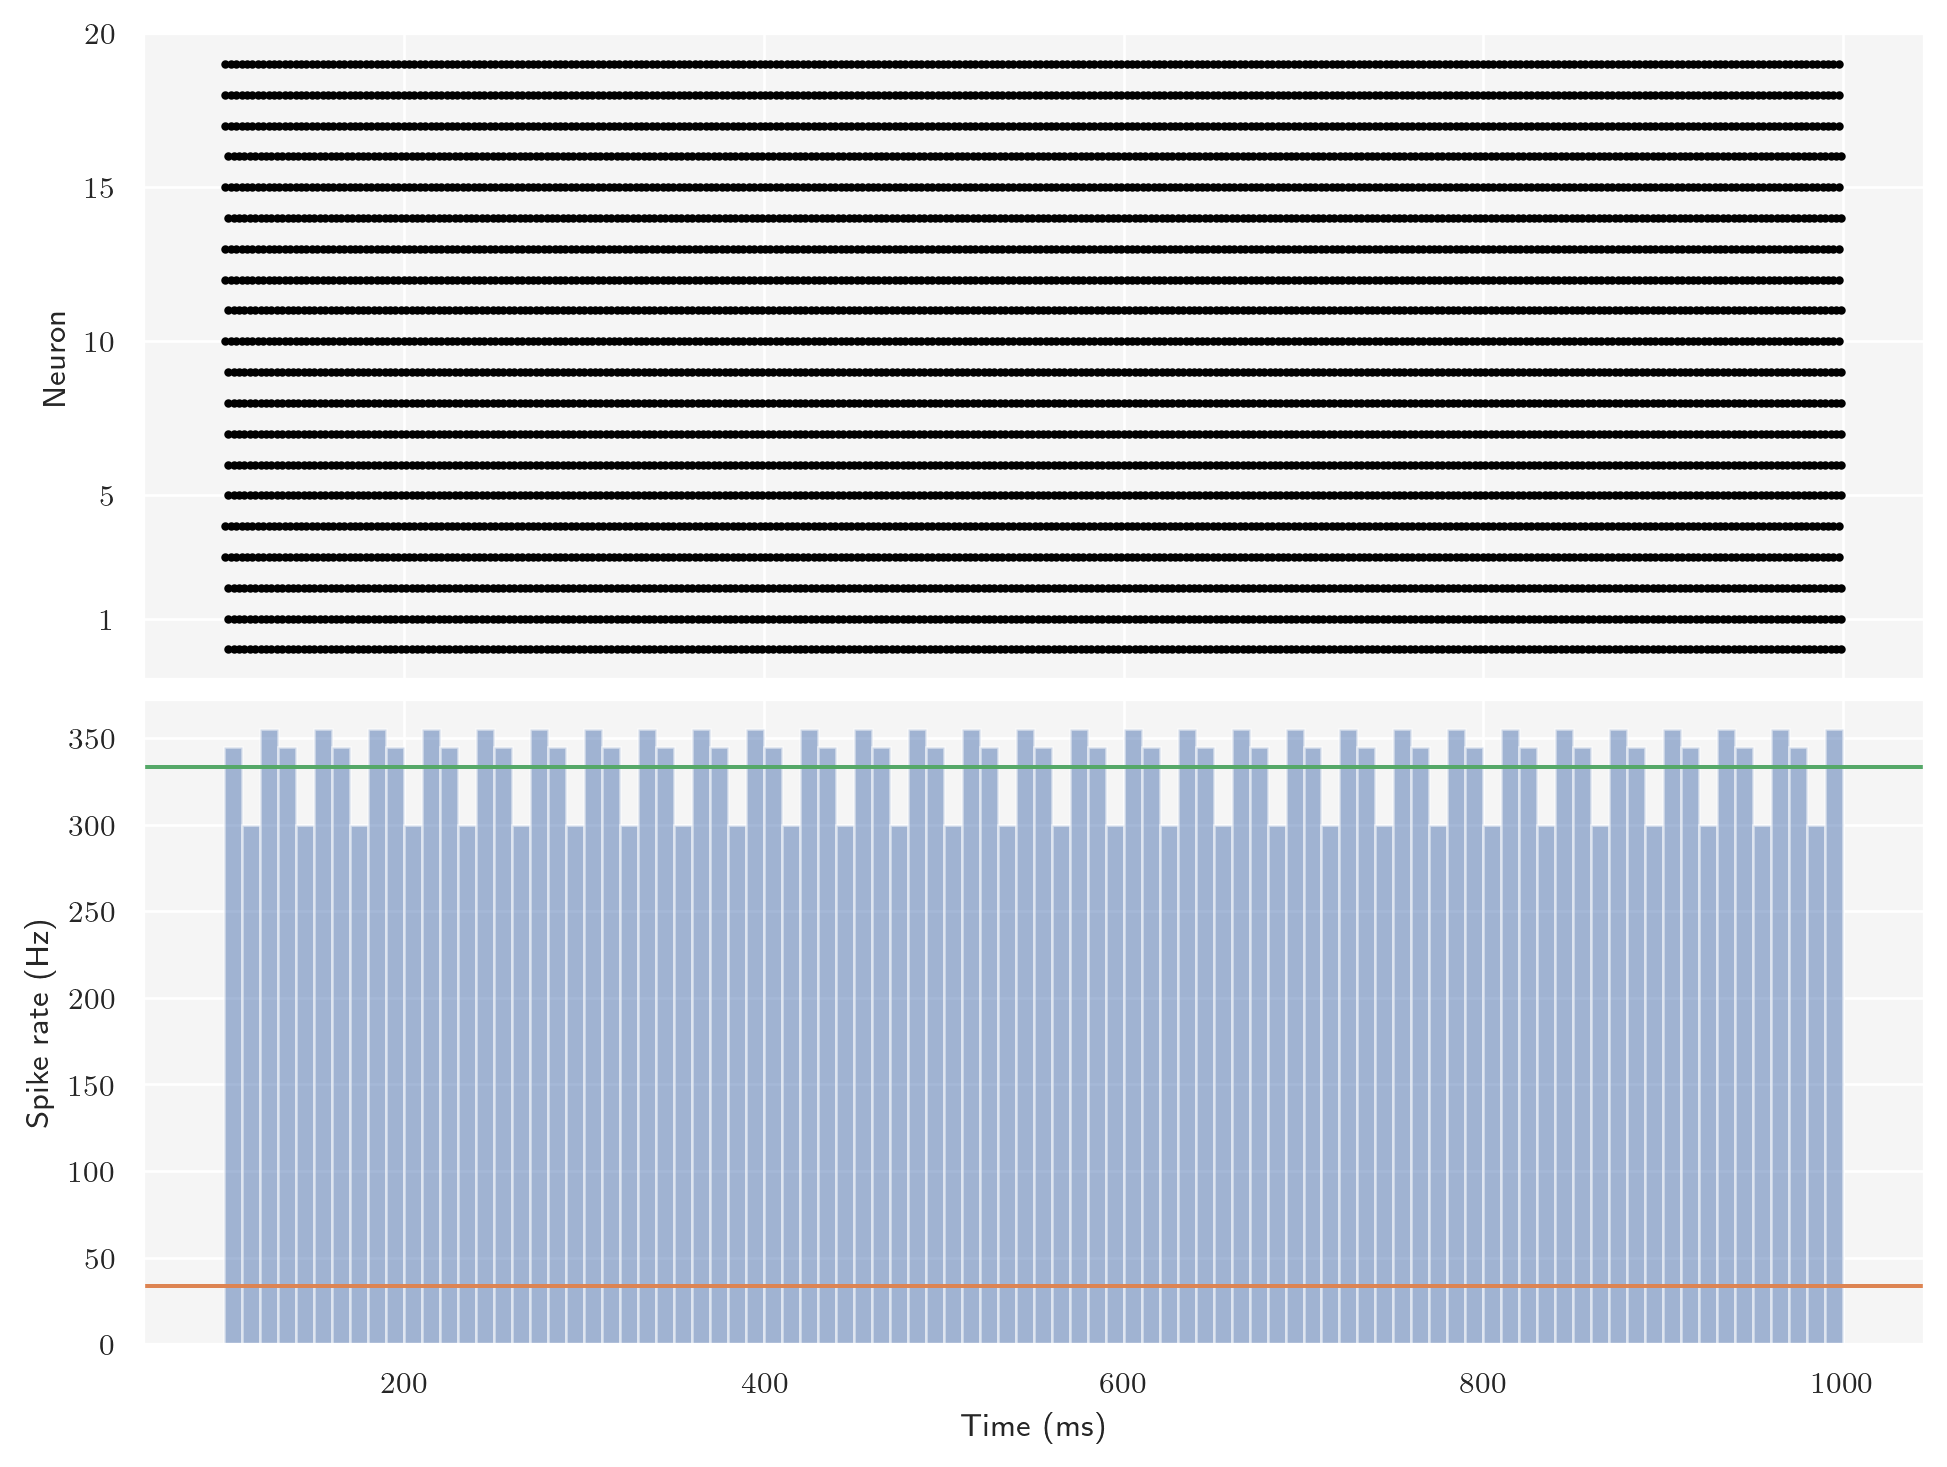

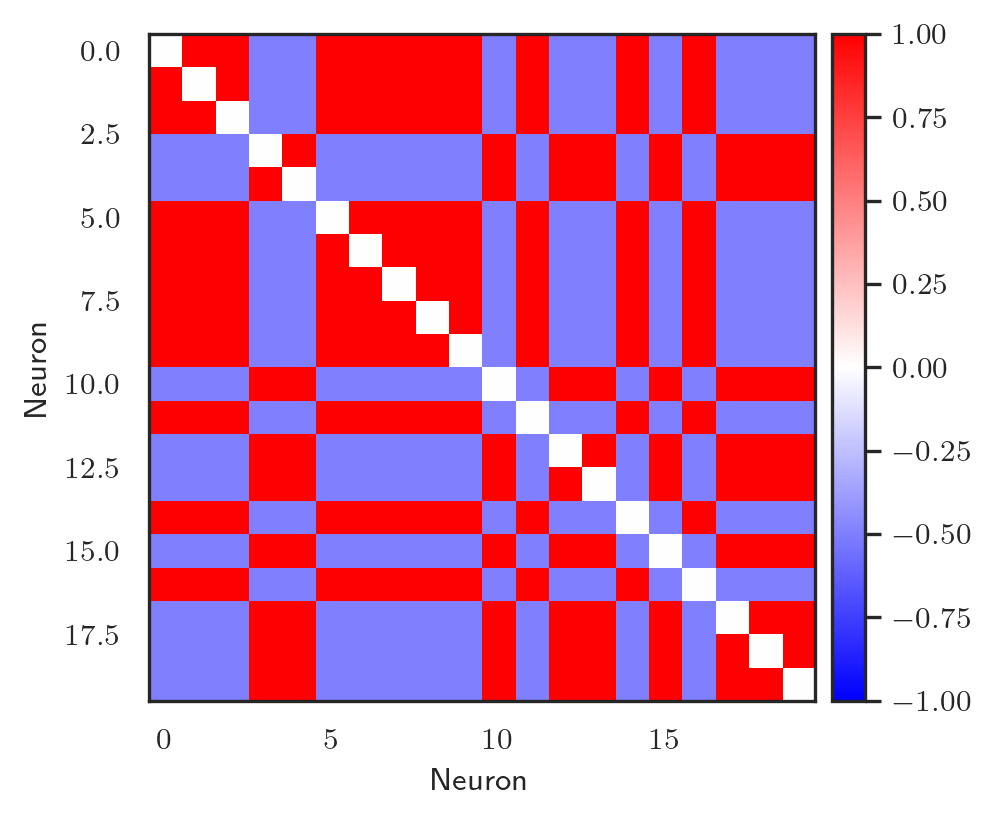

In [7]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_sr_slice = slice_spiketrains(spiketrains_sr,
                                         t_start=t_start,
                                         t_stop=t_stop
                                        )

hist_sr = statistics.time_histogram(spiketrains_sr_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_sr = sts.mean_firing_rate(spiketrains_sr_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_sr_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_sr.times, 
            hist_sr.magnitude.flatten() * 1000, 
            width=hist_sr.sampling_period, 
            align='edge', 
            alpha=0.5)


axes[1].axhline(np.mean(hist_sr.T[0]) * 1000, color='C3')  # population average 
axes[1].axhline(mean_frate_sr * 1000, color='C2')          # sanity check, should overlap with above
axes[1].axhline(np.sum(hist_sr.T[0])/ (t_stop - t_start) * 1000, color='C1')  # temporal average

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains = BinnedSpikeTrain(spiketrains_sr_slice, bin_size=10 * pq.ms)
corrcoef_matrix = correlation_coefficient(binned_spiketrains)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

**A: Almost fully synchronized network, neurons firing regularly at high rates.**

### Brunel AI state

$g = 5$, $\eta = 2$

In [8]:
g_ai = 5.   
eta_ai = 2.  

spiketrains_ai = bnet(eta=eta_ai, g=g_ai)


 85 %: network time: 846.0 ms, realtime factor: 0.2813

100 %: network time: 999.0 ms, realtime factor: 0.2687


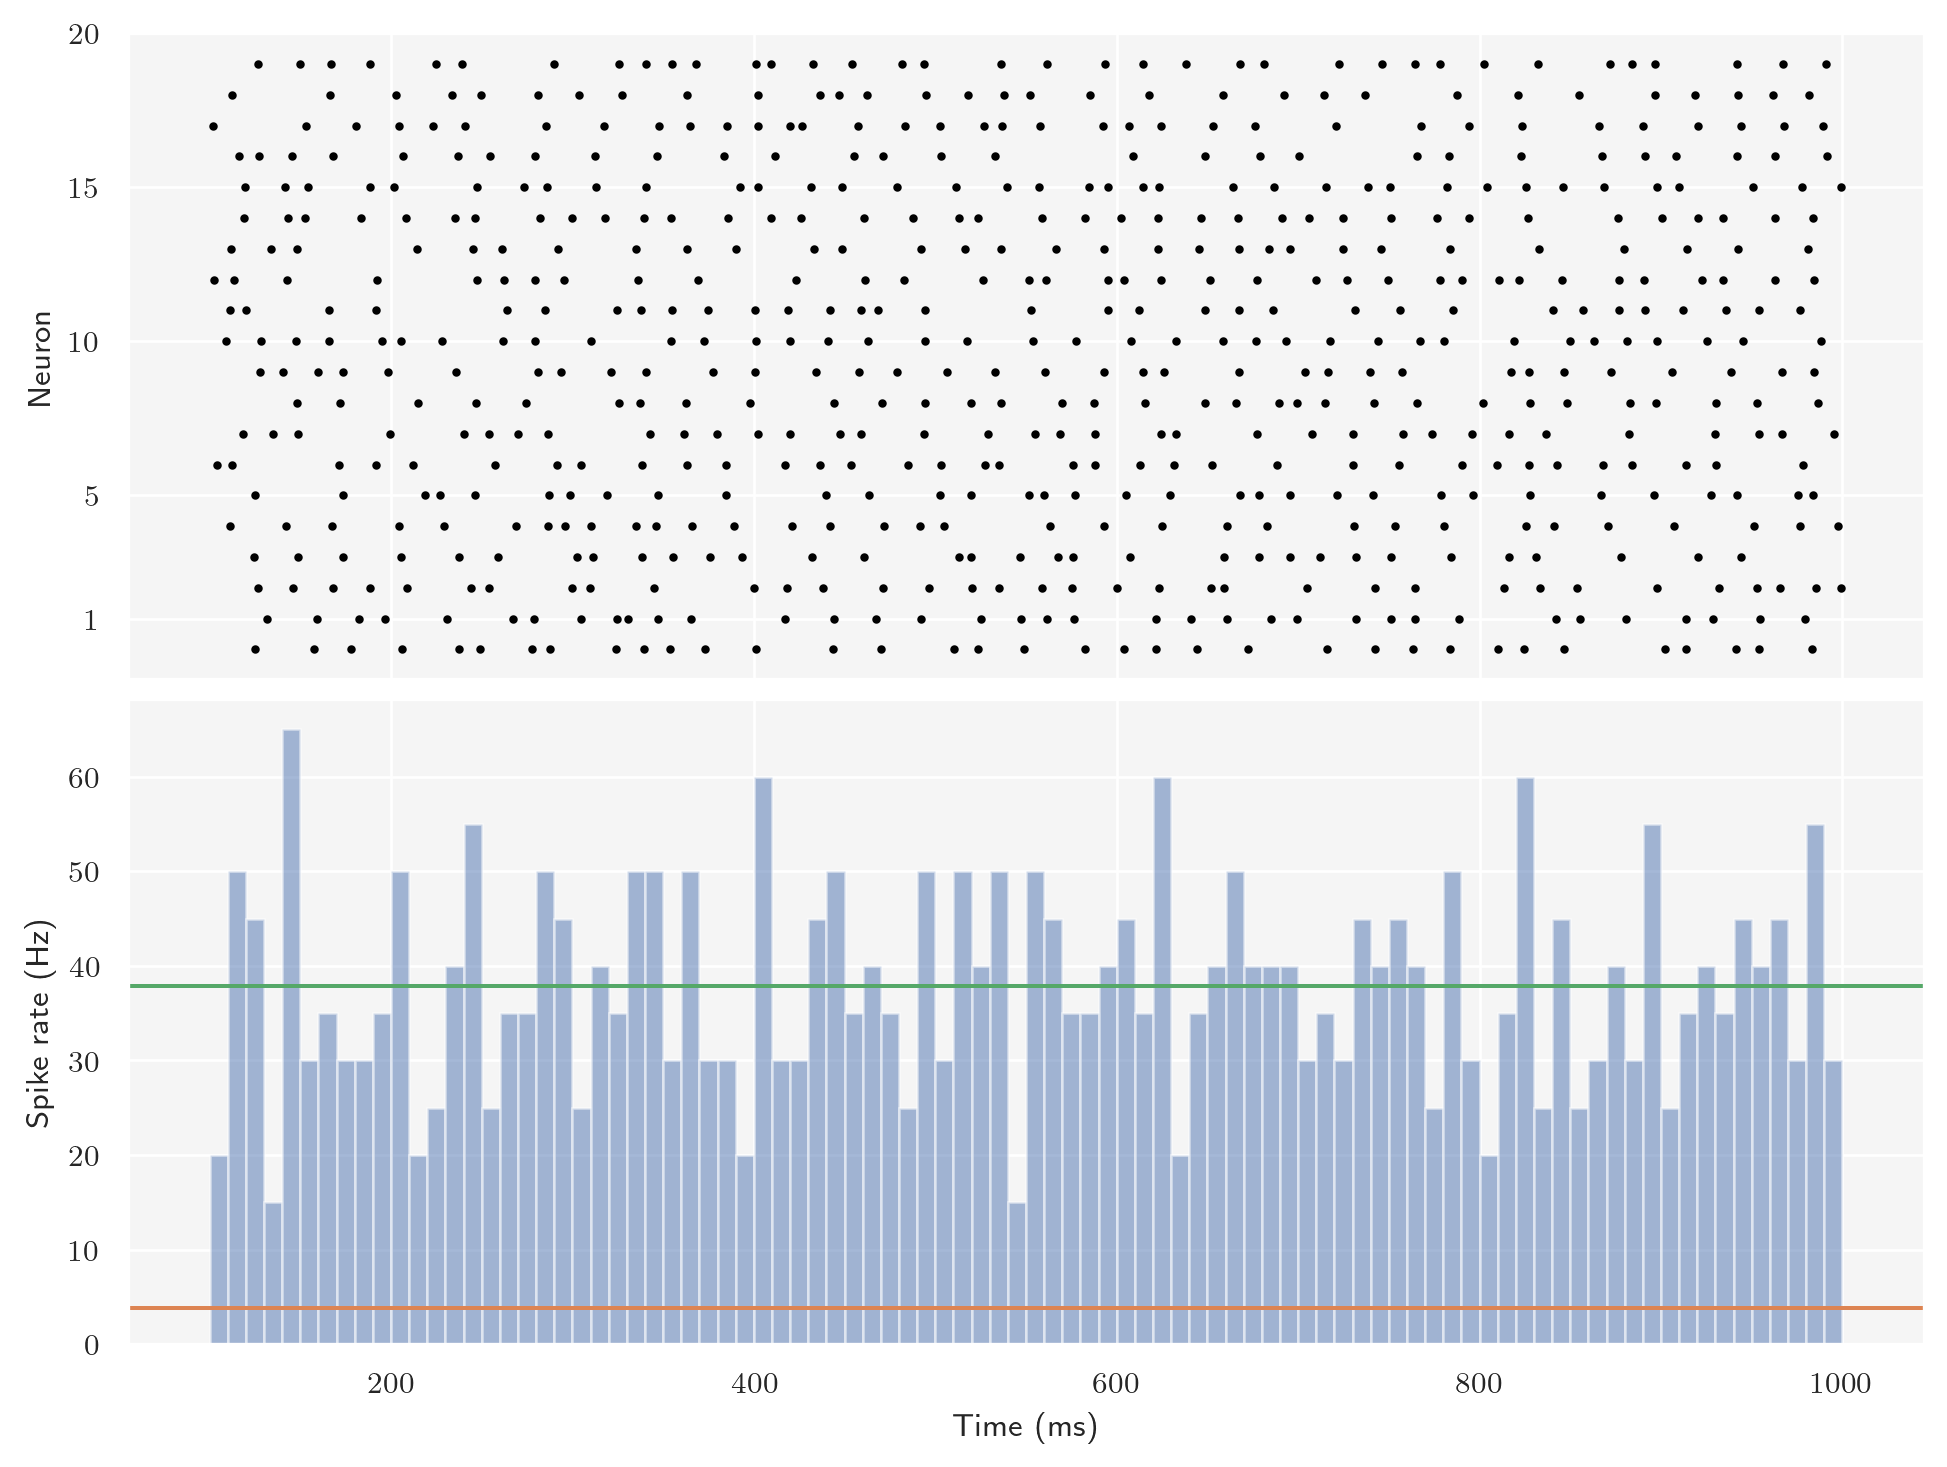

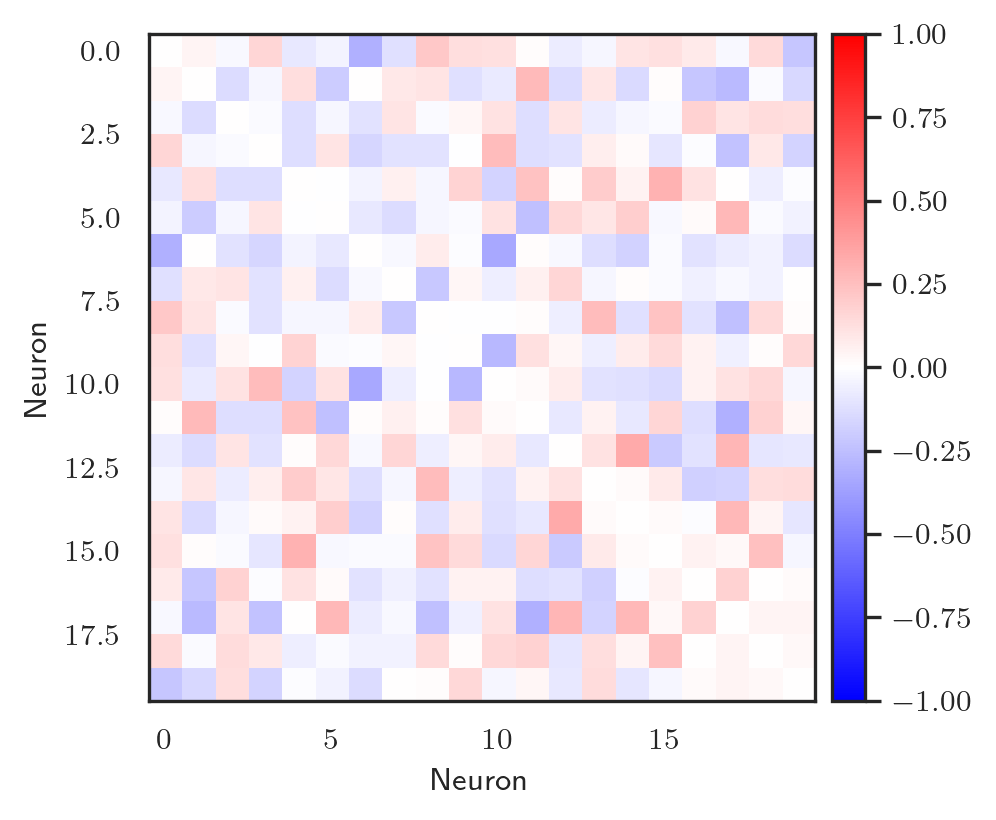

In [9]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_ai_slice = slice_spiketrains(spiketrains_ai,
                                         t_start=t_start,
                                         t_stop=t_stop
                                         )

hist_ai = statistics.time_histogram(spiketrains_ai_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_ai = sts.mean_firing_rate(spiketrains_ai_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_ai_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_ai.times, 
            hist_ai.magnitude.flatten() * 1000, 
            width=hist_ai.sampling_period, 
            align='edge', 
            alpha=0.5)

axes[1].axhline(np.mean(hist_ai.T[0]) * 1000, color='C3')  # population average 
axes[1].axhline(mean_frate_ai * 1000, color='C2')          # sanity check, should overlap with above
axes[1].axhline(np.sum(hist_ai.T[0])/ (t_stop - t_start) * 1000, color='C1')  # temporal average

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains_ai = BinnedSpikeTrain(spiketrains_ai_slice, bin_size=10 * pq.ms)
corrcoef_matrix_ai = correlation_coefficient(binned_spiketrains_ai)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix_ai, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

**Stationary global activity (see text), irregularly firing neurons**

### Brunel SR (fast) state

$g = 6$, $\eta = 4$

In [10]:
g_srf = 6.   
eta_srf = 4.  

spiketrains_srf = bnet(eta=eta_srf, g=g_srf)


 74 %: network time: 736.5 ms, realtime factor: 0.2188

100 %: network time: 999.0 ms, realtime factor: 0.2051


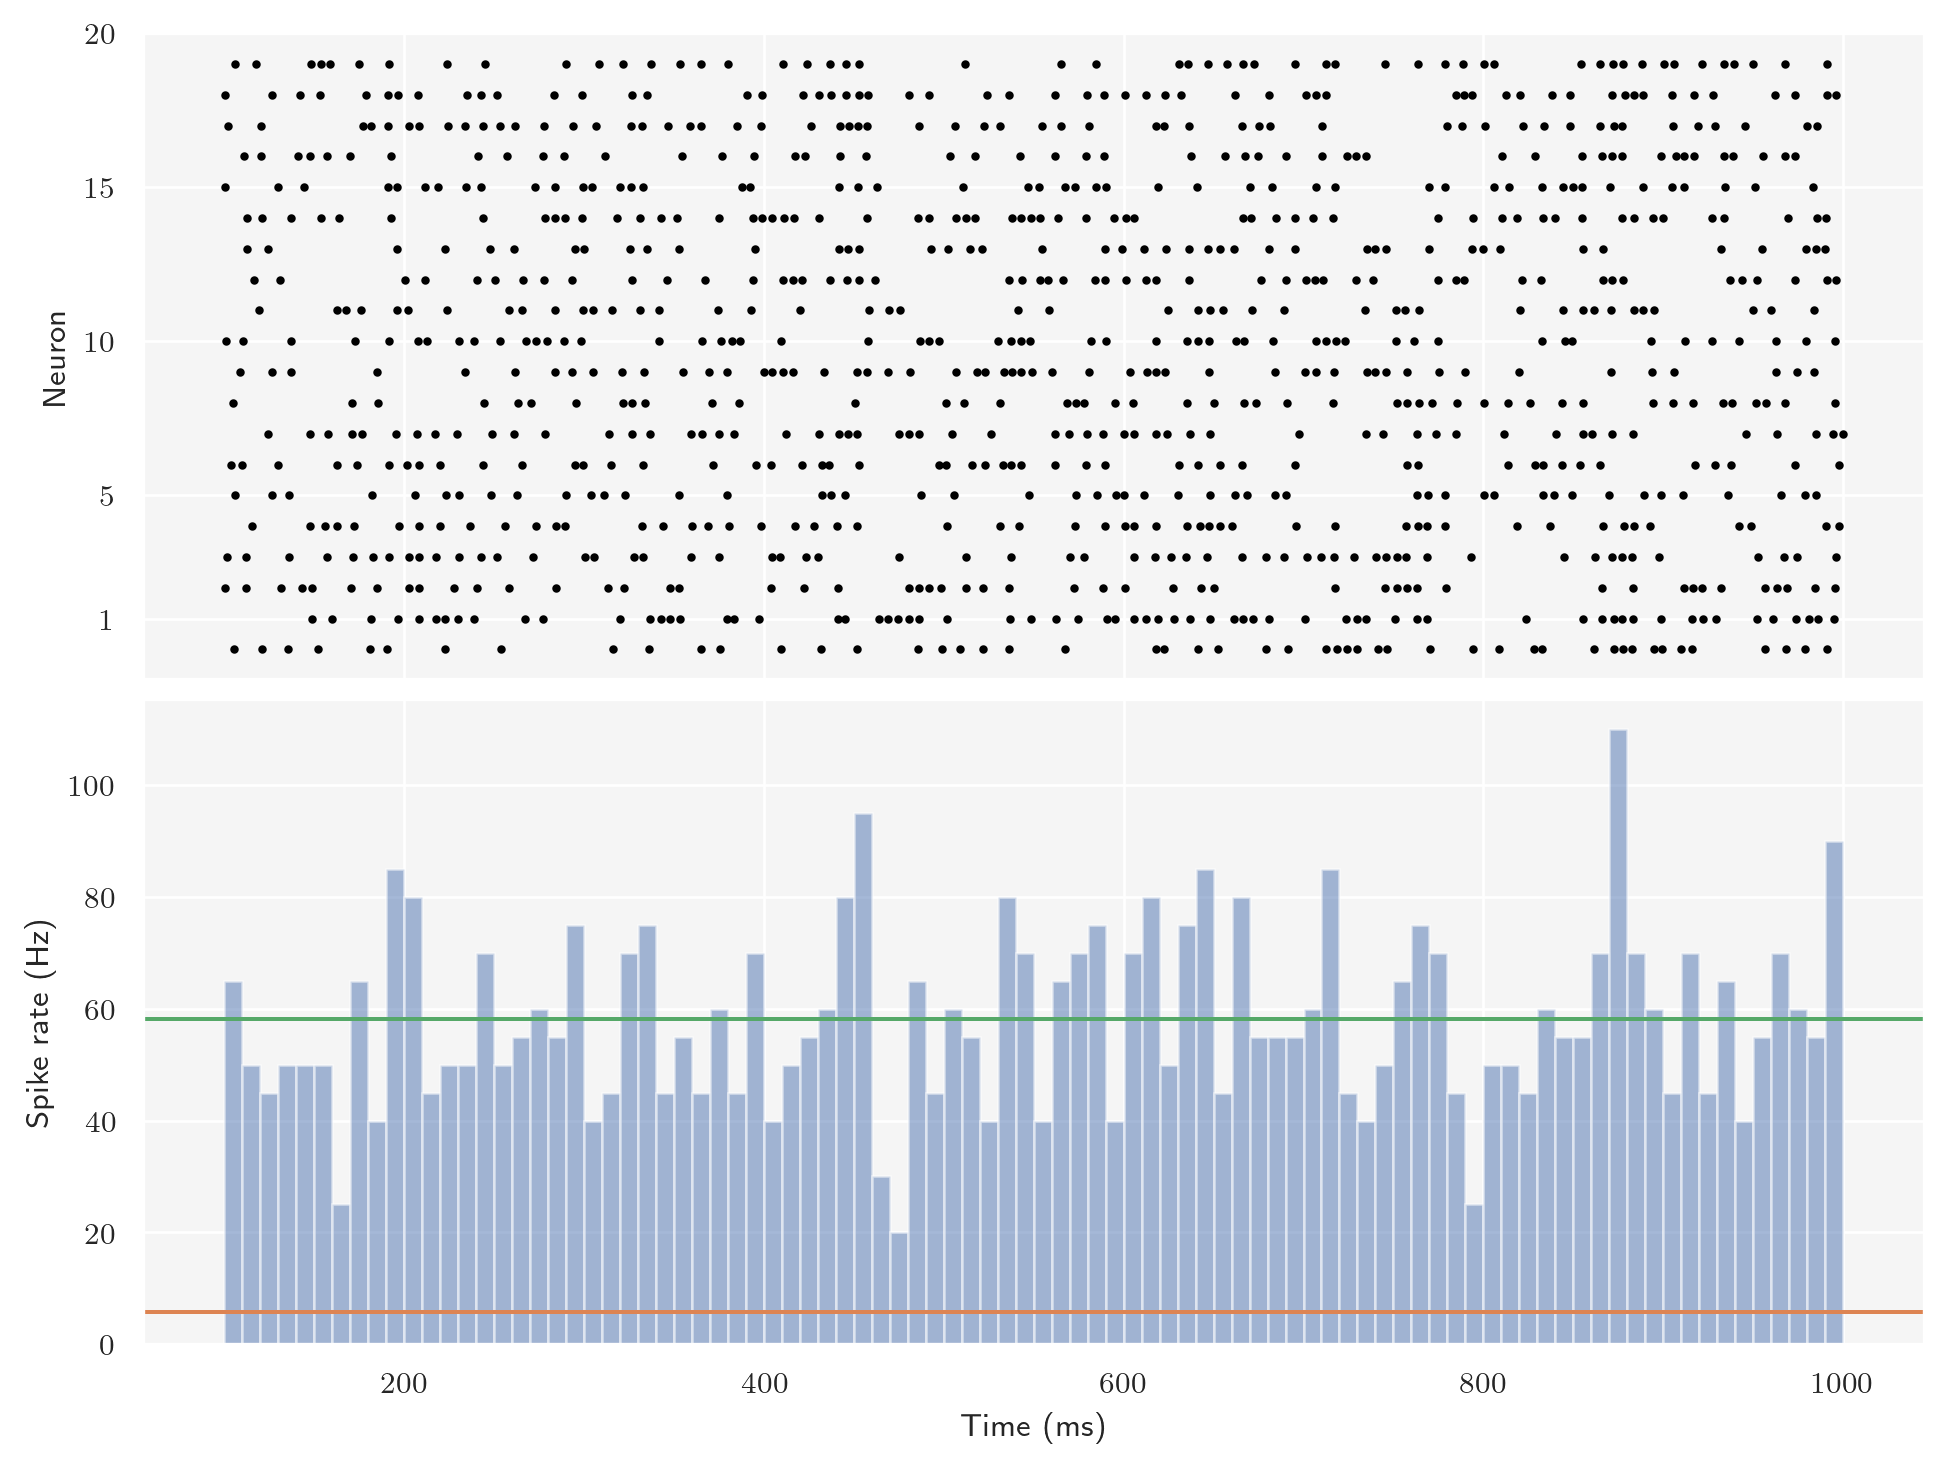

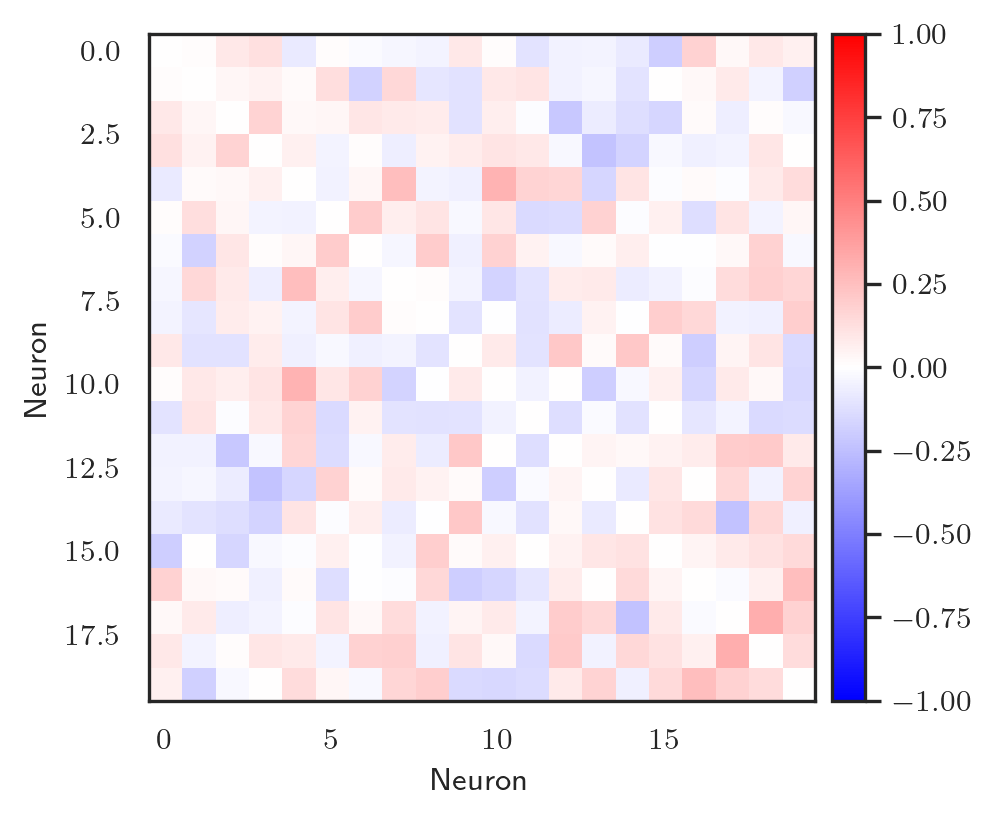

In [11]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_srf_slice = slice_spiketrains(spiketrains_srf,
                                          t_start=t_start,
                                          t_stop=t_stop
                                         )

hist_srf = statistics.time_histogram(spiketrains_srf_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_srf = sts.mean_firing_rate(spiketrains_srf_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_srf_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_srf.times, 
            hist_srf.magnitude.flatten() * 1000, 
            width=hist_srf.sampling_period, 
            align='edge', 
            alpha=0.5)

axes[1].axhline(np.mean(hist_srf.T[0]) * 1000, color='C3')  # population average 
axes[1].axhline(mean_frate_srf * 1000, color='C2')          # sanity check, should overlap with above
axes[1].axhline(np.sum(hist_srf.T[0])/ (t_stop - t_start) * 1000, color='C1')  # temporal average

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains_srf = BinnedSpikeTrain(spiketrains_srf_slice, bin_size=10 * pq.ms)
corrcoef_matrix_srf = correlation_coefficient(binned_spiketrains_srf)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix_srf, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

**Fast oscillation of the global activity, neurons firing irregularly at a rate that is lower than the global frequency**

### Brunel SR (slow) state

$g = 4.5$, $\eta = 0.9$

In [12]:
g_srs = 4.5   
eta_srs = 0.9  

spiketrains_srs = bnet(eta=eta_srs, g=g_srs)


 44 %: network time: 438.0 ms, realtime factor: 0.5506

100 %: network time: 999.0 ms, realtime factor: 0.5884


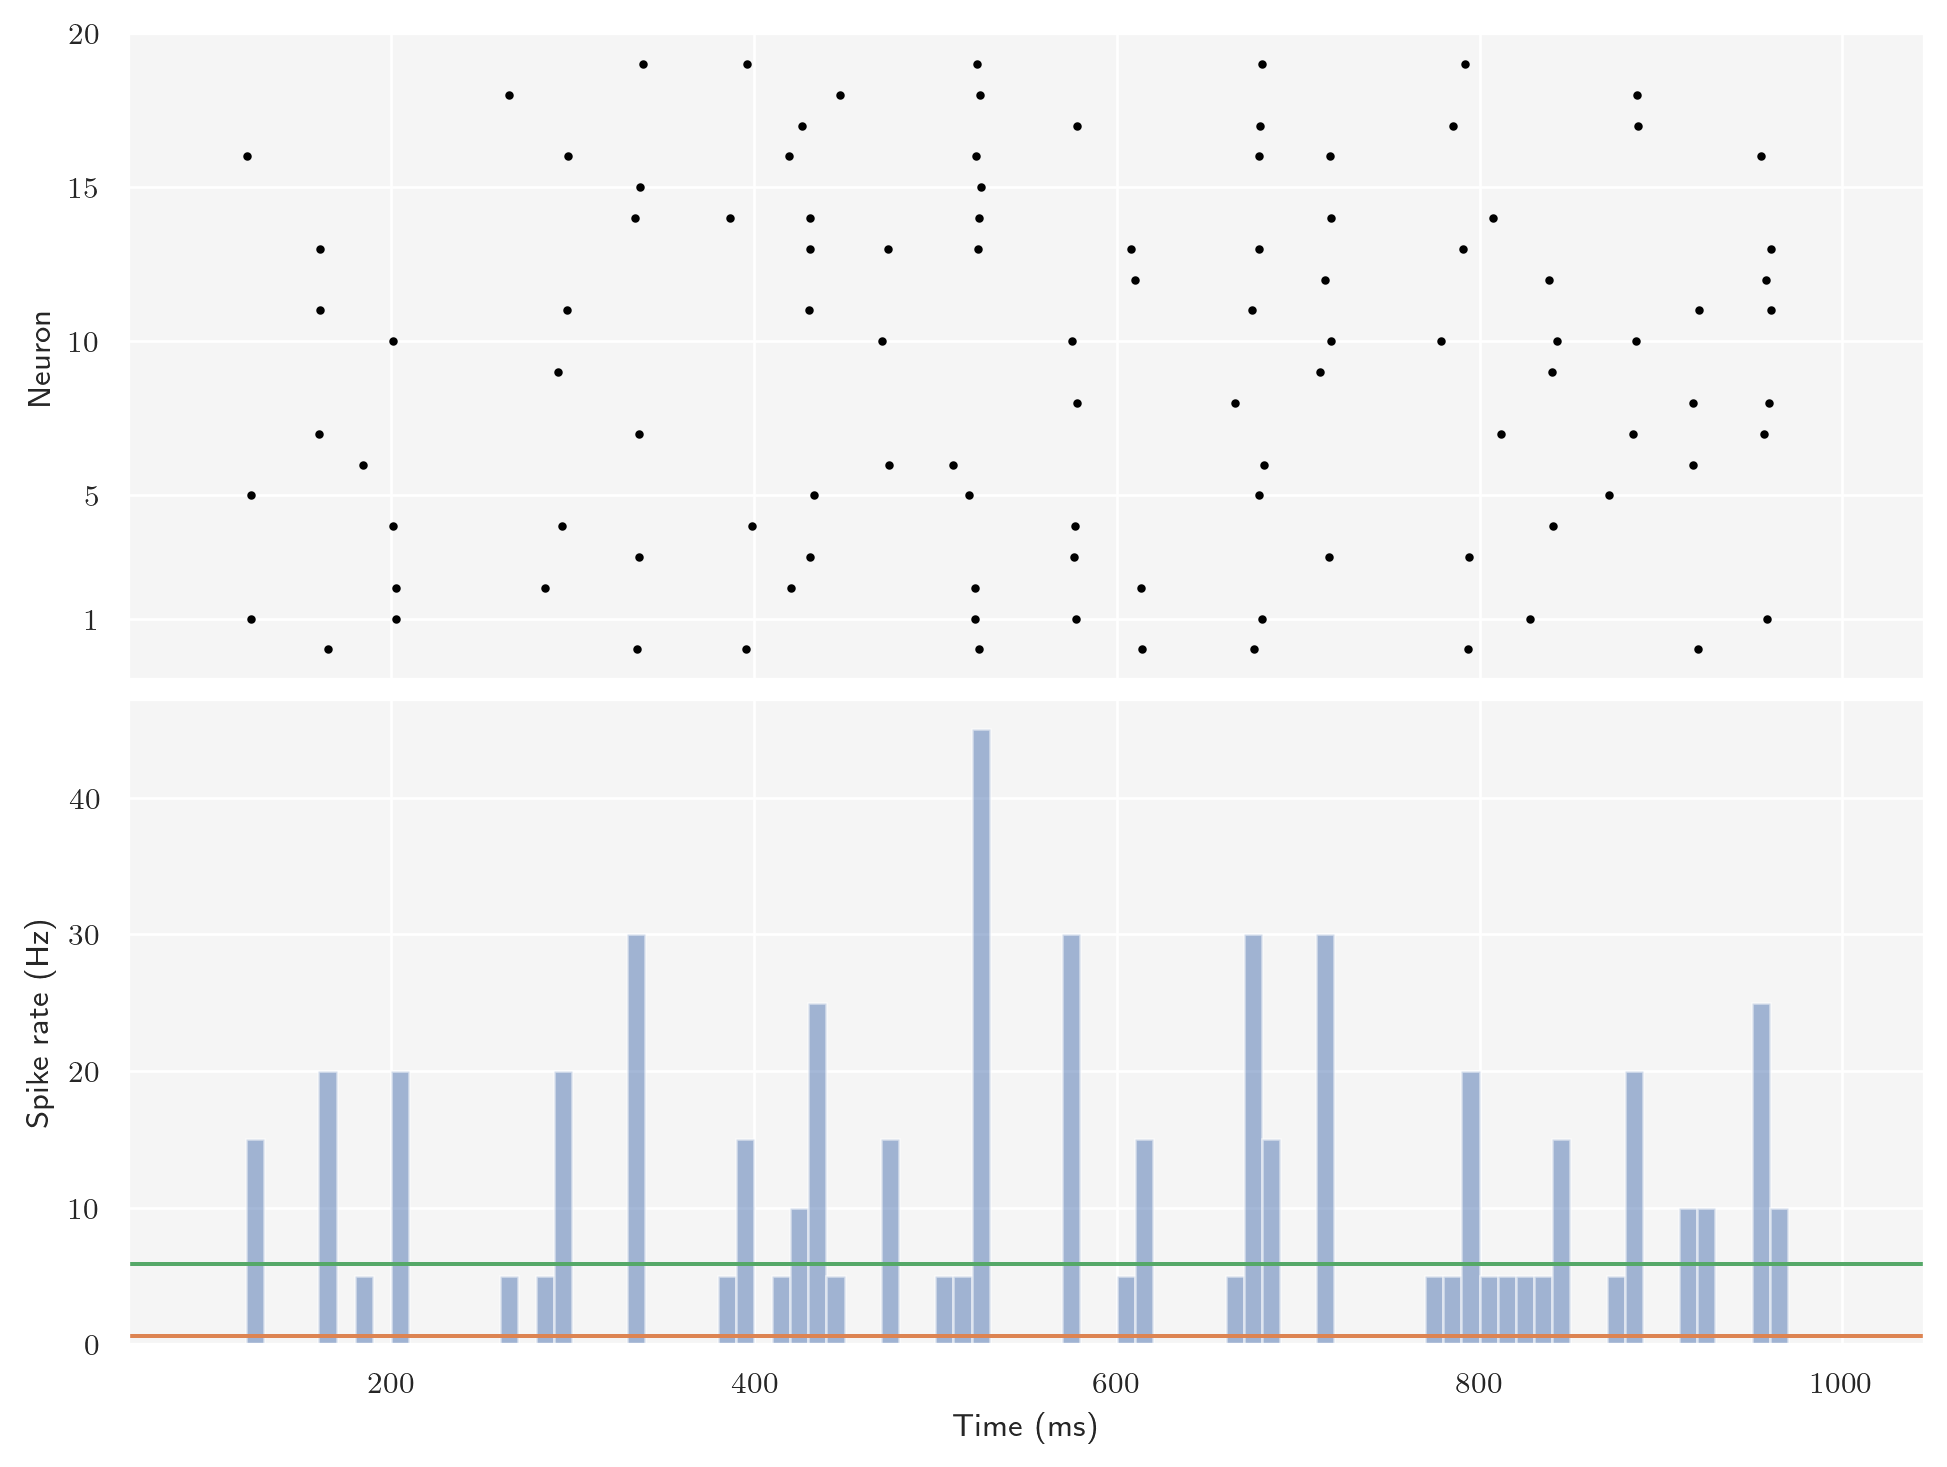

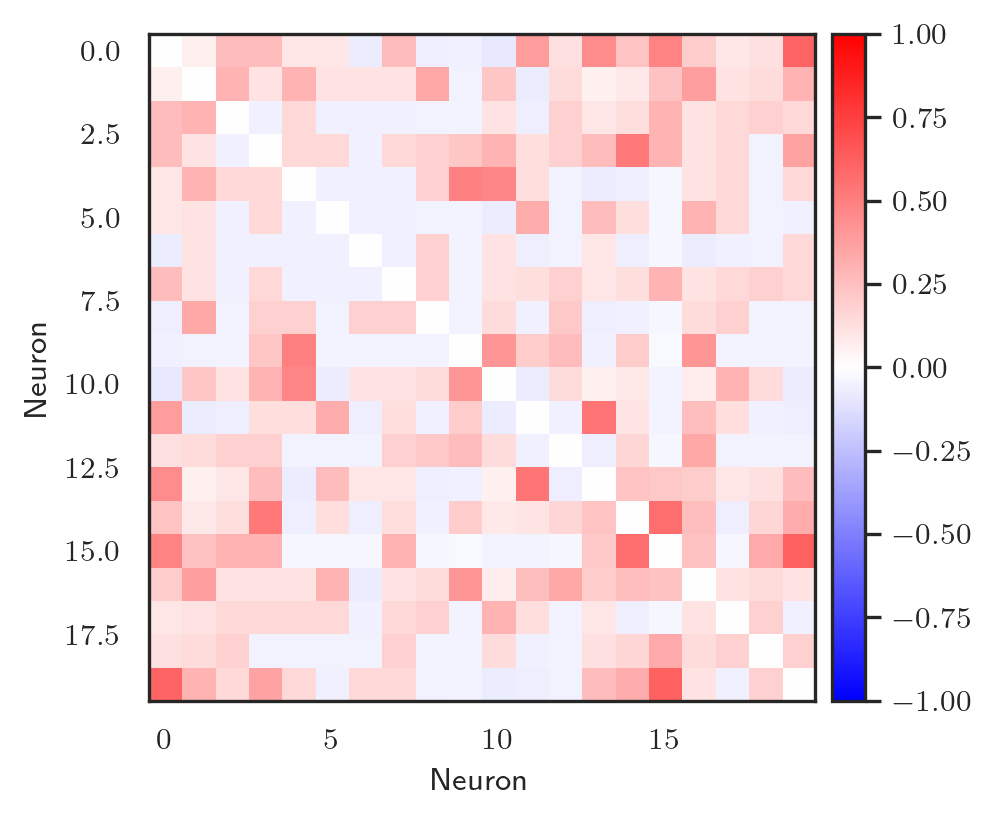

In [13]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_srs_slice = slice_spiketrains(spiketrains_srs,
                                          t_start=t_start,
                                          t_stop=t_stop
                                         )

hist_srs = statistics.time_histogram(spiketrains_srs_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_srs = sts.mean_firing_rate(spiketrains_srs_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_srs_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_srs.times, 
            hist_srs.magnitude.flatten() * 1000, 
            width=hist_srs.sampling_period, 
            align='edge', 
            alpha=0.5)

axes[1].axhline(np.mean(hist_srs.T[0]) * 1000, color='C3')  # population average 
axes[1].axhline(mean_frate_srs * 1000, color='C2')          # sanity check, should overlap with above
axes[1].axhline(np.sum(hist_srs.T[0])/ (t_stop - t_start) * 1000, color='C1')  # temporal average

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains_srs = BinnedSpikeTrain(spiketrains_srs_slice, bin_size=10 * pq.ms)
corrcoef_matrix_srs = correlation_coefficient(binned_spiketrains_srs)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix_srs, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

**Slow oscillation of the global activity, neurons firing irregularly at very low rates**

### One figure

In [5]:
# Fixed model parameters
order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# NEST settings
threads = 16        # number of threads to use in simulation
print_time = True   # print simulated time or not

# simulator model
bnet = nm.models.BrunelNet(order=order,
                           epsilon=epsilon,
                           D=D,
                           J=J,
                           T=T,
                           N_rec=N_rec,
                           n_type=n_type,
                           print_time=print_time,
                           threads=threads
                           )

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

def slice_spiketrains(spiketrains, t_start=None, t_stop=None):

    spiketrains_slice = []
    for spiketrain in spiketrains:
        if t_start is None:
            t_start = spiketrain.t_start
        if t_stop is None:
            t_stop = spiketrain.t_stop

        spiketrain_slice = spiketrain[np.where(
            (spiketrain > t_start) & (spiketrain < t_stop))]
        spiketrain_slice.t_start = t_start
        spiketrain_slice.t_stop = t_stop
        spiketrains_slice.append(spiketrain_slice)
    return spiketrains_slice

In [12]:
eta_sr = 2. 
g_sr = 3.   

spiketrains_sr = bnet(eta=eta_sr, g=g_sr)


100 %: network time: 999.0 ms, realtime factor: 0.0583


In [6]:
eta_ai = 2. 
g_ai = 5.   

spiketrains_ai = bnet(eta=eta_ai, g=g_ai)


 69 %: network time: 682.5 ms, realtime factor: 0.3370

In [89]:
eta_sif = 4. 
g_sif = 6.    

spiketrains_sif = bnet(eta=eta_sif, g=g_sif)


100 %: network time: 999.0 ms, realtime factor: 0.1902


In [90]:
eta_sis = 0.9 
g_sis = 4.5    

spiketrains_sis = bnet(eta=eta_sis, g=g_sis)


 44 %: network time: 438.0 ms, realtime factor: 0.7344

In [94]:
def plot_column(axes, col, spiketrains, params, col_label):
    sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

    # computations
    t_start = 100. * pq.ms
    t_stop = T * pq.ms
    spiketrains_slice = slice_spiketrains(spiketrains, t_start=t_start, t_stop=t_stop)
    hist = statistics.time_histogram(spiketrains_slice, bin_size=10 * pq.ms, output='rate')
    mean_frate = sts.mean_firing_rate(spiketrains_slice, units=1 / pq.ms)
    binned_spiketrains = BinnedSpikeTrain(spiketrains_slice, bin_size=10 * pq.ms)
    corrcoef_matrix = correlation_coefficient(binned_spiketrains)
  
    # rasterplot
    rasterplot(spiketrains_slice, s=1, c='black', axes=axes[0, col])
    
    if col == 0:
        axes[0, col].set(yticks=[0, 4, 9, 14, 19], yticklabels=[1, 5, 10, 15, 20], 
                         xticks=[], ylabel='Neuron', xlabel='')
    else:
        axes[0, col].set(yticks=[], xticks=[], ylabel='', xlabel='')
        
    axes[0, col].set_title(f'{col_label}\n' 
                           + fr'$\eta = {{{params[0]:.1f}}}$, $g = {{{params[1]:.1f}}}$',
                           loc='center'
                          )
        
    # rate plot 
    axes[1, col].bar(hist.times, 
                     hist.magnitude.flatten() * 1000, 
                     width=hist.sampling_period, 
                     color='C0',
                     edgecolor='C0',
                     align='edge',
                     alpha=1
                    )
    axes[1, col].axhline(mean_frate * 1000, color='C3', ls='-')   
    axes[1, col].axis(ymin=0, ymax=360)
    
    if col == 0:
        axes[1, col].set(yticks=[50, 175, 300], xticks=[100, 400, 700, 1000], 
                         ylabel='Spike rate (Hz)', xlabel='Time (ms)') 
    else:
        axes[1, col].set(yticks=[], xticks=[100, 400, 700, 1000],
                         ylabel='', xlabel='Time (ms)')
        
    # correlation
    with sns.axes_style("white"):
  
        plot_corrcoef(corrcoef_matrix, colormap='bwr', correlation_range='full', axes=axes[2, col])
        if col == 0:
            axes[2, col].set(xticks=[0, 10, 20], yticks=[0, 10, 20], 
                             xlabel='Neuron', ylabel='Neuron')
        else:
            axes[2, col].set(xticks=[0, 10, 20], yticks=[], xlabel='Neuron', ylabel='')

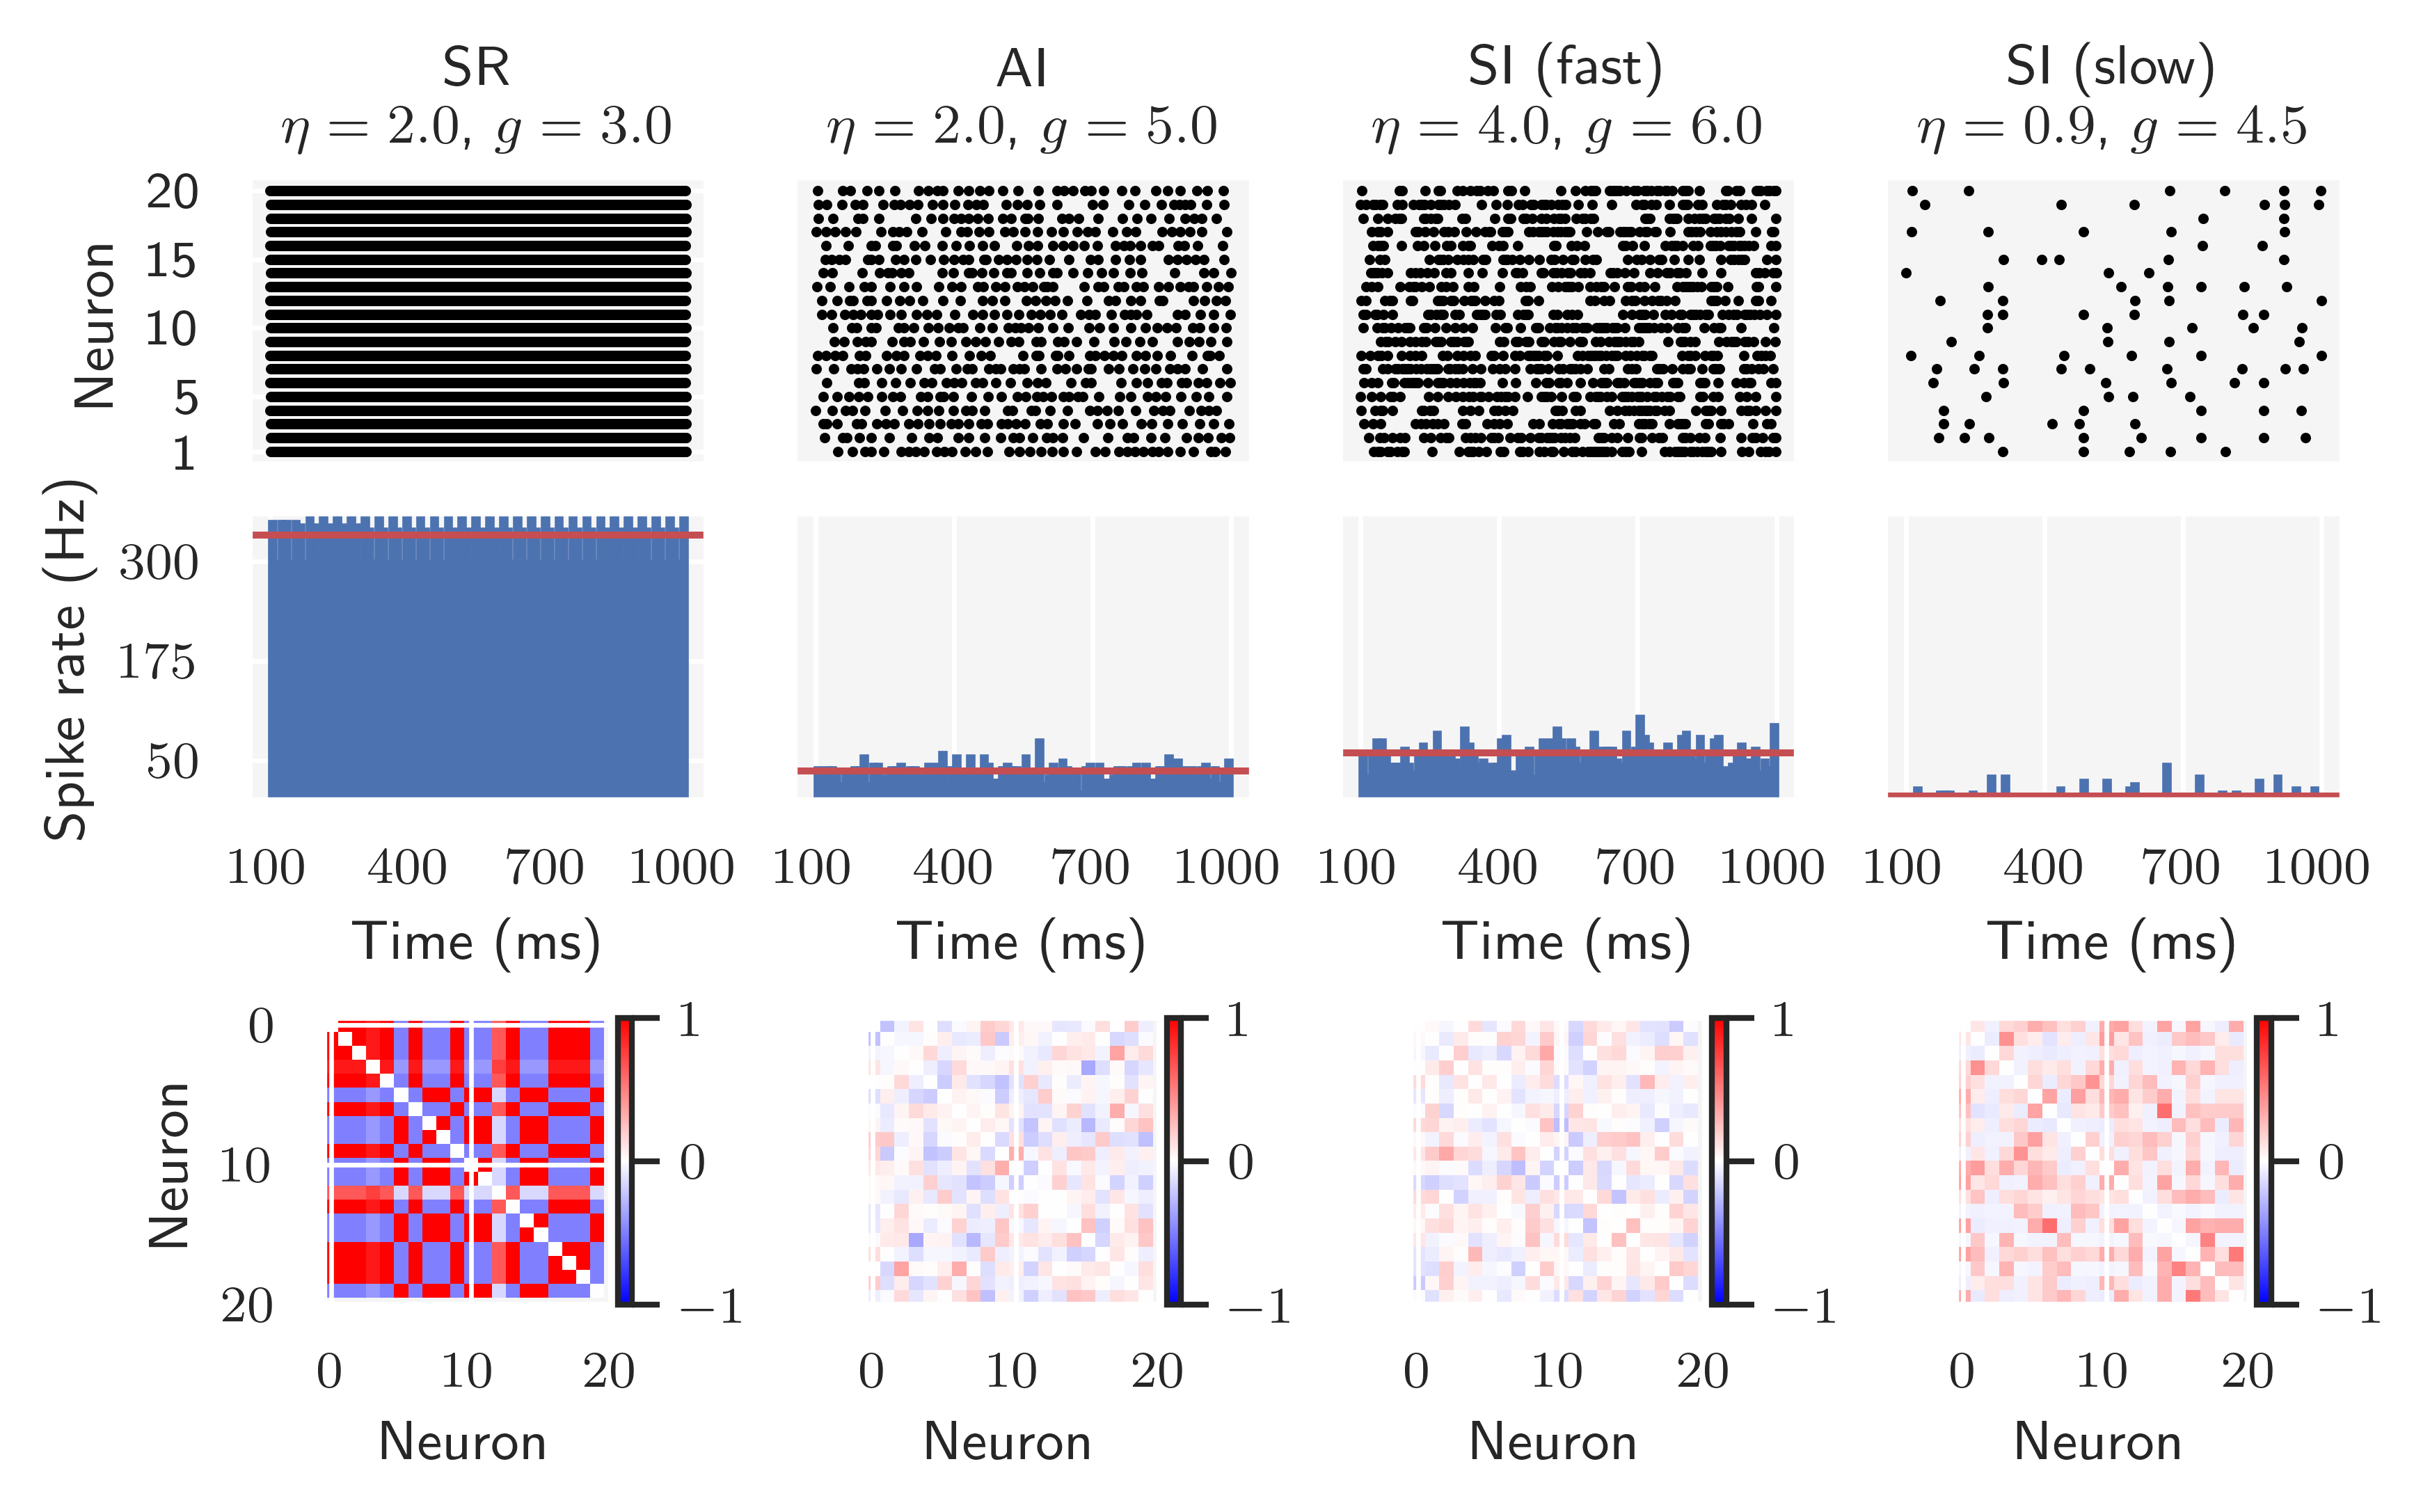

In [95]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=4, 
                         figsize=fs, 
                         constrained_layout=True, 
                         dpi=300, 
                         gridspec_kw={'height_ratios': [4, 4, 4]},
                        ) 


col_label = [r'SR', r'AI', r'SI (fast)', r'SI (slow)']
params = [[eta_sr, g_sr], [eta_ai, g_ai], [eta_sif, g_sif], [eta_sis, g_sis]]
spiketrains_all = [spiketrains_sr, spiketrains_ai, spiketrains_sif, spiketrains_sis]

for i in range(len(spiketrains_all)):
    plot_column(axes, i, spiketrains_all[i], params[i], col_label[i])
    
fig.savefig(fig_path('brunel_states.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )